# CIV1498 Project 2

## Predict MVP

Firstly, a logistic regression model is trained with pitching and batting datasets to predict a group of top players. </br>
Secondly, a linear regression model is applied to predict MVP voting scores and rank players.</br>
Thirdly, the players' rank from the model is compared with the MVP list.

In [1]:
# Import 3rd party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

## The Data

In [2]:
# Combine annual csv files
MLB_players = pd.concat(map(pd.read_csv, ['2008_data_v5.csv','2009_data_v5.csv','2010_data_v5.csv',
                                          '2011_data_v5.csv','2012_data_v5.csv','2013_data_v5.csv',
                                          '2014_data_v5.csv','2015_data_v5.csv','2016_data_v5.csv', 
                                          '2017_data_v5.csv','2018_data_v5.csv','2019_data_v5.csv', 
                                          '2020_data_v5.csv','2021_data_v5.csv']), ignore_index=True)
MLB_players = MLB_players.iloc[: , 1:]
MLB_players

,player_id,last_name,first_name,year,league,player_age,rank,vote_points,1st_place,mvp_share,...,xba,xslg,woba,xwoba,xobp,xiso,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel_batted_rate
0,430631,Abercrombie,Reggie,2008,NL,27,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,110029,Abreu,Bobby,2008,AL,34,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,430894,Aguila,Chris,2008,NL,29,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,425769,Alfonzo,Eliezer,2008,NL,29,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,110189,Alou,Moises,2008,NL,42,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10209,605548,Zimmer,Bradley,2021,AL,29,0,0,0,0,...,0.225,0.372,0.300,0.317,0.327,0.147,90.7,7.0,30.4,9.4
10210,475582,Zimmerman,Ryan,2021,NL,37,0,0,0,0,...,0.232,0.419,0.319,0.300,0.277,0.187,91.3,7.4,32.2,10.6
10211,572287,Zunino,Mike,2021,AL,30,20,1,0,0,...,0.220,0.535,0.358,0.355,0.305,0.315,90.7,23.2,31.7,24.3
10212,518595,d'Arnaud,Travis,2021,NL,32,0,0,0,0,...,0.248,0.406,0.291,0.312,0.309,0.158,89.9,5.9,33.8,7.6


In [3]:
print(MLB_players.isnull().sum())

player_id                0
last_name                0
first_name               0
year                     0
league                 147
player_age               0
rank                     0
vote_points              0
1st_place                0
mvp_share                0
Total WAR              146
WAR_bat                146
WAR_pit                146
b_ab                     0
b_total_pa               0
b_total_hits             0
b_single                 0
b_double                 0
b_triple                 0
b_home_run               0
b_strikeout              0
b_walk                   0
b_k_percent              0
b_bb_percent             0
batting_avg              0
slg_percent              0
on_base_percent          0
on_base_plus_slg         0
b_game                   0
r_run                    0
xba                   5205
xslg                  5205
woba                  5205
xwoba                 5205
xobp                  5205
xiso                  5205
exit_velocity_avg     5207
l

In [4]:
# drop NaN value

MLB_players = MLB_players.drop(columns= ['xba','xslg','woba','xwoba','xobp','xiso','exit_velocity_avg','launch_angle_avg','sweet_spot_percent','barrel_batted_rate'])
MLB_players = MLB_players.dropna(how='any')    #drop if any value in the row has a nan
print(MLB_players.isnull().sum())

player_id           0
last_name           0
first_name          0
year                0
league              0
player_age          0
rank                0
vote_points         0
1st_place           0
mvp_share           0
Total WAR           0
WAR_bat             0
WAR_pit             0
b_ab                0
b_total_pa          0
b_total_hits        0
b_single            0
b_double            0
b_triple            0
b_home_run          0
b_strikeout         0
b_walk              0
b_k_percent         0
b_bb_percent        0
batting_avg         0
slg_percent         0
on_base_percent     0
on_base_plus_slg    0
b_game              0
r_run               0
dtype: int64


In [5]:
# Strip white space from column names and names
MLB_players.columns = MLB_players.columns.str.strip()
MLB_players['first_name'] = MLB_players['first_name'].str.strip()
MLB_players['last_name'] = MLB_players['last_name'].str.strip()

# Combine first and last names
MLB_players['name'] = MLB_players.agg(lambda x: f"{x['first_name']} {x['last_name']}", axis=1)

MLB_players.head()

,player_id,last_name,first_name,year,league,player_age,rank,vote_points,1st_place,mvp_share,...,b_walk,b_k_percent,b_bb_percent,batting_avg,slg_percent,on_base_percent,on_base_plus_slg,b_game,r_run,name
0,430631,Abercrombie,Reggie,2008,NL,27,0,0,0,0,...,1,38.3,1.7,0.309,0.509,0.333,0.842,34,10,Reggie Abercrombie
1,110029,Abreu,Bobby,2008,AL,34,0,0,0,0,...,73,15.9,10.7,0.296,0.471,0.371,0.843,156,100,Bobby Abreu
2,430894,Aguila,Chris,2008,NL,29,0,0,0,0,...,2,26.7,13.3,0.167,0.167,0.267,0.433,8,0,Chris Aguila
3,425769,Alfonzo,Eliezer,2008,NL,29,0,0,0,0,...,0,36.4,0.0,0.091,0.091,0.091,0.182,5,0,Eliezer Alfonzo
4,110189,Alou,Moises,2008,NL,42,0,0,0,0,...,2,7.4,3.7,0.347,0.388,0.389,0.777,15,4,Moises Alou


# Train/Test split

In [6]:
# add a lebel for top players if they were voted as MVP candidates.
MLB_players['Top_players'] = MLB_players['vote_points'].apply(lambda x: 1 if x > 0 else 0)
MLB_players.head(5)

,player_id,last_name,first_name,year,league,player_age,rank,vote_points,1st_place,mvp_share,...,b_k_percent,b_bb_percent,batting_avg,slg_percent,on_base_percent,on_base_plus_slg,b_game,r_run,name,Top_players
0,430631,Abercrombie,Reggie,2008,NL,27,0,0,0,0,...,38.3,1.7,0.309,0.509,0.333,0.842,34,10,Reggie Abercrombie,0
1,110029,Abreu,Bobby,2008,AL,34,0,0,0,0,...,15.9,10.7,0.296,0.471,0.371,0.843,156,100,Bobby Abreu,0
2,430894,Aguila,Chris,2008,NL,29,0,0,0,0,...,26.7,13.3,0.167,0.167,0.267,0.433,8,0,Chris Aguila,0
3,425769,Alfonzo,Eliezer,2008,NL,29,0,0,0,0,...,36.4,0.0,0.091,0.091,0.091,0.182,5,0,Eliezer Alfonzo,0
4,110189,Alou,Moises,2008,NL,42,0,0,0,0,...,7.4,3.7,0.347,0.388,0.389,0.777,15,4,Moises Alou,0


In [7]:
train_top = MLB_players[MLB_players['year'] <= 2018]
test_top = MLB_players[MLB_players['year'] > 2018]
print('Train:', train_top.shape, 'Test:', test_top.shape)
print('Test/Train: {:.2f} %'.format(test_top.shape[0]/train_top.shape[0]*100))
print('Train Top players proportion: {:.2f} %'.format(train_top['Top_players'][train_top['Top_players'] == 1].shape[0] / train_top.shape[0] * 100))
print('Test Top players proportion: {:.2f} %'.format(test_top['Top_players'][test_top['Top_players'] == 1].shape[0] / test_top.shape[0] * 100))

Train: (7981, 32) Test: (2086, 32)
Test/Train: 26.14 %
Train Top players proportion: 5.99 %
Test Top players proportion: 5.99 %


# Annual data normalize

In [8]:
from sklearn.preprocessing import StandardScaler

# Define numerical features to use for modelling
num_features = ['player_age', 'WAR_bat', 'WAR_pit', 'b_ab', 'b_total_pa', 'b_total_hits', 'b_single', 'b_double', 'b_triple', 
                'b_home_run', 'b_strikeout', 'b_walk', 'batting_avg', 'slg_percent', 'on_base_percent',  'b_game', 'r_run']

# Define categorical features to use for modelling
cat_features = ['name', 'Top_players' , 'year' , 'league' , 'vote_points', 'rank']

# Fit scaler (basically get the mean and stdev) for the data
def Annual_scaler(df):
    
    x=[]
    for year in df.year.unique():
        scaler = StandardScaler()
        scaler.fit(df[num_features][df['year'] == year])
    
        scaled = df[num_features][df['year']== year].copy()
        scaled.iloc[:, :] = scaler.transform(scaled)
        x.append(scaled)

    return pd.concat(x)

def create_features(df):
    """Create a feature set from taxi ride dataframe df."""
    
    scaled = df[num_features].copy()
    
    # Convert numeric features to standard units
    df_scaled = Annual_scaler(df).reset_index()
    
    # Convert categorical features
    categoricals = df[cat_features].copy().reset_index()
    
    return pd.concat([categoricals , df_scaled], axis=1).drop(columns = ['index'])

# Let's test our function
create_features(train_top)

,name,Top_players,year,league,vote_points,rank,player_age,WAR_bat,WAR_pit,b_ab,...,b_double,b_triple,b_home_run,b_strikeout,b_walk,batting_avg,slg_percent,on_base_percent,b_game,r_run
0,Reggie Abercrombie,0,2008,NL,0,0,-0.476017,-0.256776,-0.237024,-0.892098,...,-0.599568,-0.637359,-0.527984,-0.576897,-0.902669,1.101530,1.204819,0.500048,-0.810564,-0.683104
1,Bobby Abreu,0,2008,AL,0,0,1.131682,1.122906,-0.237024,1.880867,...,2.071636,1.444395,1.422455,1.632839,2.044548,0.914710,0.916781,0.947481,1.598140,2.154704
2,Chris Aguila,0,2008,NL,0,0,-0.016675,-0.624692,-0.237024,-1.107328,...,-0.992392,-0.637359,-0.744700,-1.065094,-0.861736,-0.939120,-1.387527,-0.277073,-1.323895,-0.998416
3,Eliezer Alfonzo,0,2008,NL,0,0,-0.016675,-0.735066,-0.237024,-1.112333,...,-0.992392,-0.637359,-0.744700,-1.065094,-0.943603,-2.031299,-1.963604,-2.349396,-1.383125,-0.998416
4,Moises Alou,0,2008,NL,0,0,2.969052,-0.471394,-0.237024,-0.922130,...,-0.835262,-0.637359,-0.744700,-1.065094,-0.861736,1.647619,0.287644,1.159423,-1.185690,-0.872291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7976,Mike Zunino,0,2018,AL,0,0,-0.360816,0.675086,-0.248002,0.752870,...,0.568229,-0.637904,1.348143,2.056649,0.111555,-0.177692,0.517447,-0.171676,0.790085,0.256787
7977,Travis d'Arnaud,0,2018,NL,0,0,0.169952,-0.543826,-0.248002,-1.094223,...,-0.975054,-0.637904,-0.723592,-1.130756,-0.890069,-0.192047,0.442751,-0.278858,-1.375774,-0.972736
7978,Chase d'Arnaud,0,2018,NL,0,0,0.700720,-0.462147,-0.217823,-0.691784,...,-0.546364,-0.637904,-0.505515,-0.427328,-0.759422,0.023281,0.188784,-0.278858,-0.620704,-0.699509
7979,Jacob deGrom,1,2018,NL,141,5,0.435336,-0.210824,9.710995,-0.825930,...,-0.889316,-0.637904,-0.832631,-0.691114,-0.759422,-0.708834,-1.208032,-0.838587,-0.859147,-0.972736


# 2. Linear regression - predict MVP vote points directly

In [9]:
# X_train drop columns related to MVP voting and string column 
X_train_MVP = create_features(train_top).drop(columns = ['name', 'Top_players' , 'year' , 'vote_points', 'rank' , 'Top_players','league'])
y_train_MVP = create_features(train_top)['vote_points']

In [10]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression(fit_intercept=True)

linear_model.fit(X_train_MVP, y_train_MVP)
y_train_MVP_pred = linear_model.predict(X_train_MVP)

In [11]:
def rmse(errors):
    """Return the root mean squared error."""
    return np.sqrt(np.mean(errors ** 2))

train_rmse = rmse(y_train_MVP- y_train_MVP_pred)

# Print score
print('Linear regression model validation RMSE: {0:0.2f} points'.format(train_rmse))

Linear regression model validation RMSE: 25.19 points


## Linear regression - TEST

The top 6 players in the model only have 3 of 4 real MVPs though RMSE is small. 

In [12]:
X_test_MVP = create_features(test_top).drop(columns = ['name', 'Top_players' , 'year' , 'vote_points', 'rank' , 'Top_players','league'])
y_test_MVP = create_features(test_top)['vote_points']

y_test_MVP_pred = linear_model.predict(X_test_MVP)

In [13]:
test_rmse = rmse(y_test_MVP - y_test_MVP_pred)

# Print score
print('Linear regression model validation RMSE: {0:0.2f} points'.format(test_rmse))

Linear regression model validation RMSE: 26.96 points


In [14]:
MVP_linear_pred = pd.concat([test_top.reset_index(), pd.DataFrame(y_test_MVP_pred)], axis=1).rename(columns={0: 'Pred_points'})
MVP_linear_pred.head(5)

,index,player_id,last_name,first_name,year,league,player_age,rank,vote_points,1st_place,...,b_bb_percent,batting_avg,slg_percent,on_base_percent,on_base_plus_slg,b_game,r_run,name,Top_players,Pred_points
0,8128,547989,Abreu,Jose,2019,AL,32,19,5,0,...,5.2,0.284,0.503,0.330,0.834,159,85,Jose Abreu,1,18.759142
1,8129,660670,Acuna Jr.,Ronald,2019,NL,22,5,155,0,...,10.6,0.280,0.518,0.364,0.881,156,127,Ronald Acuna Jr.,1,54.946313
2,8130,642715,Adames,Willy,2019,AL,24,0,0,0,...,7.9,0.254,0.418,0.315,0.733,152,69,Willy Adames,0,7.981991
3,8131,542436,Adames,Cristhian,2019,NL,28,0,0,0,...,8.3,0.318,0.364,0.375,0.739,10,1,Cristhian Adames,0,1.834049
4,8132,571431,Adams,Matt,2019,NL,31,0,0,0,...,6.0,0.226,0.465,0.276,0.741,111,42,Matt Adams,0,-4.491527


In [15]:
# Top 5 predicted vote points contain 2 MVPs
MVP_linear_pred[['name','rank','year','vote_points','Pred_points', 'league']].sort_values(by=['Pred_points'], ascending=False).head(5)

,name,rank,year,vote_points,Pred_points,league
938,Freddie Freeman,1,2020,410,112.100705,NL
1582,Vladimir Guerrero Jr.,2,2021,269,111.243972,AL
82,Alex Bregman,2,2019,335,110.990096,AL
1963,Juan Soto,2,2021,274,110.168161,NL
58,Cody Bellinger,1,2019,362,109.031885,NL


In [16]:
MVP_linear_pred[['name','rank','year','vote_points','Pred_points', 'league']].sort_values(by=['Pred_points'], ascending=False).drop_duplicates(['year','league']).sort_values(by=['year', 'league'], ascending=False)

,name,rank,year,vote_points,Pred_points,league
1963,Juan Soto,2,2021,274,110.168161,NL
1582,Vladimir Guerrero Jr.,2,2021,269,111.243972,AL
938,Freddie Freeman,1,2020,410,112.100705,NL
1044,DJ LeMahieu,3,2020,230,88.194684,AL
58,Cody Bellinger,1,2019,362,109.031885,NL
82,Alex Bregman,2,2019,335,110.990096,AL


# 3.1 Logistic regression - find top players

In [17]:
# X_train drop columns related to MVP voting and string column 
X_train_top = create_features(train_top).drop(columns = ['name', 'Top_players' , 'year' , 'vote_points', 'rank'  ,'league'])
y_train_top = create_features(train_top)['Top_players']

In [18]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(fit_intercept=True)
log_model.fit(X_train_top, y_train_top)

LogisticRegression()

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

In [20]:
y_train_top_pred = log_model.predict(X_train_top)
y_train_top_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [21]:
pd.DataFrame(y_train_top_pred).value_counts()

0    7569
1     412
dtype: int64

In [22]:
accuracy_score(y_train_top,y_train_top_pred)

0.9744392933216389

In [23]:
cm = confusion_matrix(y_train_top,y_train_top_pred)

print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[1,1])
print('\nTrue Negatives(TN) = ', cm[0,0])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

Confusion matrix

 [[7434   69]
 [ 135  343]]

True Positives(TP) =  343

True Negatives(TN) =  7434

False Positives(FP) =  69

False Negatives(FN) =  135


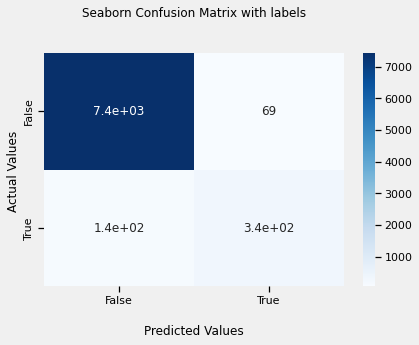

In [24]:
ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
ax.set_ylim(2.0, 0)
## Display the visualization of the Confusion Matrix.
plt.show()

In [25]:
precision = TP / float(TP + FP)
recall = TP / float(TP + FN)
f1 = f1_score(y_train_top,y_train_top_pred,average='macro')
print('Precision : {0:0.4f}'.format(precision))
print('Recall or Sensitivity : {0:0.4f}'.format(recall))
print('f1 : {0:0.4f}'.format(f1))

Precision : 0.8325
Recall or Sensitivity : 0.7176
f1 : 0.8786


## Logistic regression - TEST

In [26]:
X_test_top = create_features(test_top).drop(columns = ['name', 'Top_players' , 'year' , 'vote_points', 'rank' , 'Top_players','league'])
y_test_top = create_features(test_top)['Top_players']

y_test_top_pred = log_model.predict(X_test_top)
y_test_top_pred

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [27]:
pd.DataFrame(y_test_top_pred).value_counts()

0    1977
1     109
dtype: int64

In [28]:
accuracy_score(y_test_top,y_test_top_pred)

0.9702780441035475

In [29]:
cm = confusion_matrix(y_test_top,y_test_top_pred)

print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[1,1])
print('\nTrue Negatives(TN) = ', cm[0,0])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

Confusion matrix

 [[1938   23]
 [  39   86]]

True Positives(TP) =  86

True Negatives(TN) =  1938

False Positives(FP) =  23

False Negatives(FN) =  39


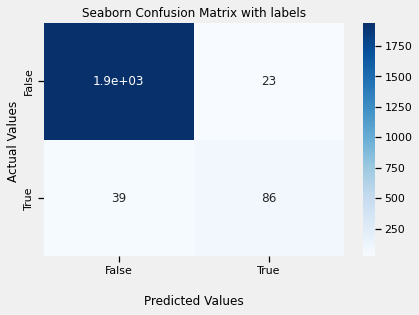

In [30]:
ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
ax.set_ylim(2.0, 0)
## Display the visualization of the Confusion Matrix.
plt.show()

In [31]:
precision = TP / float(TP + FP)
recall = TP / float(TP + FN)
f1 = f1_score(y_test_top,y_test_top_pred,average='macro')
print('Precision : {0:0.4f}'.format(precision))
print('Recall or Sensitivity : {0:0.4f}'.format(recall))
print('f1 : {0:0.4f}'.format(f1))

Precision : 0.7890
Recall or Sensitivity : 0.6880
f1 : 0.8596


# 3.2 Linear regression 2 
## predict MVP vote points from predicted top players


In [32]:
# Prepare the predicted top players dataframe
df = pd.concat([create_features(train_top.reset_index()), pd.DataFrame(y_train_top_pred)], axis=1).rename(columns={0: 'Pred_Top_players'})

# Build a linear model to predict MVPs from top players
X_train_MVP2 = df[df['Pred_Top_players'] == 1].drop(columns = ['name', 'Top_players' , 'year' , 'vote_points', 'rank' , 'Pred_Top_players','league'])
y_train_MVP2 = df[df['Pred_Top_players'] == 1]['vote_points']

In [33]:
linear_model2 = LinearRegression(fit_intercept=True)

linear_model2.fit(X_train_MVP2, y_train_MVP2)
y_train_MVP_pred2 = linear_model2.predict(X_train_MVP2)

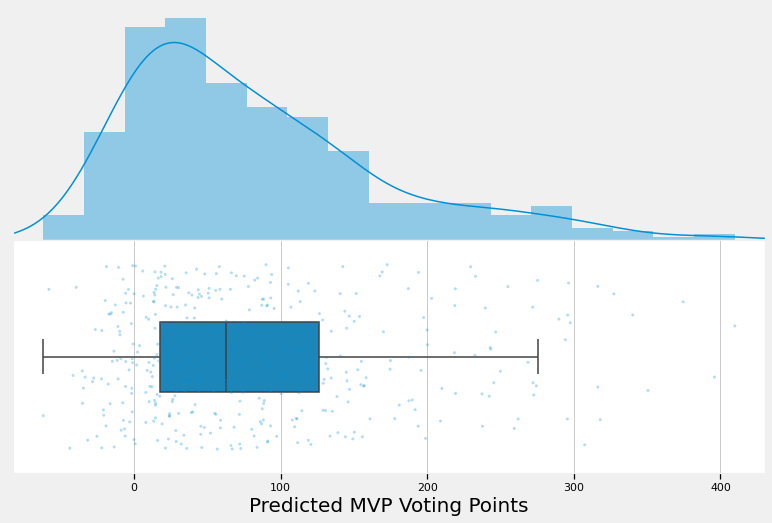

In [34]:
# Examine target variable WAR using three different plot types
fig, axs = plt.subplots(figsize=(12, 8), nrows=2)

sns.distplot(
    y_train_MVP_pred2, 
    ax=axs[0]
)
sns.stripplot(
    y_train_MVP_pred2, 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    y_train_MVP_pred2,
    width=0.3, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(y_train_MVP_pred2) * 0.05
xmin = np.min(y_train_MVP_pred2) - spacer
xmax = np.max(y_train_MVP_pred2) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)
axs[1].set_xlabel('Predicted MVP Voting Points', fontsize=20)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white .artists[0]
axs[1].set_facecolor('white')

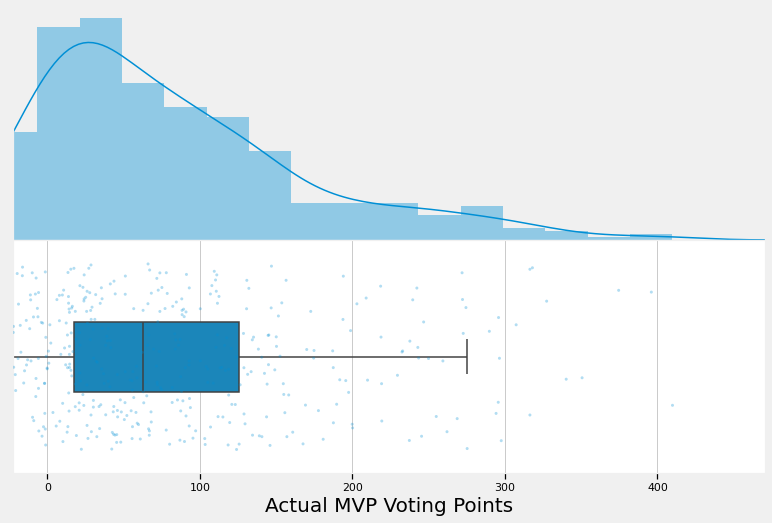

In [35]:
# Examine target variable WAR using three different plot types
fig, axs = plt.subplots(figsize=(12, 8), nrows=2)

sns.distplot(
    y_train_MVP_pred2, 
    ax=axs[0]
)
sns.stripplot(
    y_train_MVP_pred2, 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    y_train_MVP_pred2,
    width=0.3, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(y_train_MVP) * 0.05
xmin = np.min(y_train_MVP) - spacer
xmax = np.max(y_train_MVP) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)
axs[1].set_xlabel('Actual MVP Voting Points', fontsize=20)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white .artists[0]
axs[1].set_facecolor('white')

In [36]:
train_rmse2 = rmse(y_train_MVP2- y_train_MVP_pred2)
print("The mean squared error (MSE) on train set: {:.4f}".format(train_rmse2))

The mean squared error (MSE) on train set: 63.4836


In [37]:
# Explore the coefficients for each of the independent attributes
 
for idx, col_name in enumerate(X_train_MVP2.columns):
    print("The coefficient for {} is {:.2f}".format(col_name, linear_model2.coef_[idx]))

The coefficient for player_age is -10.98
The coefficient for WAR_bat is 41.29
The coefficient for WAR_pit is 48.09
The coefficient for b_ab is -399.22
The coefficient for b_total_pa is 165.12
The coefficient for b_total_hits is 290.18
The coefficient for b_single is -51.00
The coefficient for b_double is 1.34
The coefficient for b_triple is 4.73
The coefficient for b_home_run is 47.98
The coefficient for b_strikeout is -12.77
The coefficient for b_walk is -7.01
The coefficient for batting_avg is 1.24
The coefficient for slg_percent is -40.79
The coefficient for on_base_percent is 16.18
The coefficient for b_game is 26.96
The coefficient for r_run is 20.37


## Linear regression 2 - TEST
find 3 of 4 MVP in top 5 players

In [38]:
# Prepare the predicted top players dataframe
df = pd.concat([create_features(test_top.reset_index()), pd.DataFrame(y_test_top_pred)], axis=1).rename(columns={0: 'Pred_Top_players'})
df = df[df['Pred_Top_players'] == 1]

# Build a linear model to predict MVPs from top players
X_test_MVP2 = df.drop(columns = ['name', 'Top_players' , 'year' , 'vote_points', 'rank' , 'Pred_Top_players','league'])
y_test_MVP2 = df['vote_points']

In [39]:
y_test_MVP_pred2 = linear_model2.predict(X_test_MVP2)

test_rmse2 = rmse(y_test_MVP2- y_test_MVP_pred2)
print("The mean squared error (MSE) on test set: {:.4f}".format(test_rmse2))

The mean squared error (MSE) on test set: 61.8303


In [40]:
MVP_linear_pred2 = pd.concat([df.reset_index(), pd.DataFrame(y_test_MVP_pred2)], axis=1).rename(columns={0: 'Pred_points'})
MVP_linear_pred2.head(5)

,index,name,Top_players,year,league,vote_points,rank,player_age,WAR_bat,WAR_pit,...,b_home_run,b_strikeout,b_walk,batting_avg,slg_percent,on_base_percent,b_game,r_run,Pred_Top_players,Pred_points
0,1,Ronald Acuna Jr.,1,2019,NL,155,5,-1.709267,2.573424,-0.276096,...,2.925075,2.828933,2.397127,0.887326,1.104649,1.004474,1.674548,3.015128,1,68.905626
1,11,Ozzie Albies,0,2019,NL,0,0,-1.709267,2.446994,-0.276096,...,1.357906,1.171586,1.426058,1.096260,0.981022,0.864909,1.755076,2.221553,1,54.642811
2,21,Pete Alonso,1,2019,NL,102,7,-0.891947,2.796181,-0.276096,...,4.031311,2.719897,2.220569,0.608747,1.551080,0.934692,1.775208,2.253296,1,90.813623
3,23,Jose Altuve,0,2019,AL,0,0,0.197814,1.814844,-0.276096,...,2.003211,0.517371,0.852245,1.138046,1.324431,0.864909,1.030323,1.808894,1,-8.430545
4,34,Nolan Arenado,1,2019,NL,120,6,-0.074626,3.879866,-0.276096,...,2.925075,0.757250,1.779174,1.374838,1.551080,1.178932,1.654416,2.221553,1,195.718544


In [41]:
# Top 5 predicted vote points contain 3 MVPs
league_MVPpred = MVP_linear_pred2[['name','rank','year','vote_points','Pred_points','league']].sort_values(by=['Pred_points'], ascending=False)
league_MVPpred.head(5)

,name,rank,year,vote_points,Pred_points,league
49,Freddie Freeman,1,2020,410,328.822523,NL
95,Shohei Ohtani,1,2021,420,327.928525,AL
84,Vladimir Guerrero Jr.,2,2021,269,312.356277,AL
6,Cody Bellinger,1,2019,362,281.256046,NL
11,Alex Bregman,2,2019,335,272.961169,AL


In [42]:
# Predicted annual MVP in each league.
league_MVPpred.drop_duplicates(['year','league']).sort_values(by=['year', 'league'], ascending=False)

,name,rank,year,vote_points,Pred_points,league
103,Juan Soto,2,2021,274,244.953173,NL
95,Shohei Ohtani,1,2021,420,327.928525,AL
49,Freddie Freeman,1,2020,410,328.822523,NL
51,DJ LeMahieu,3,2020,230,214.496595,AL
6,Cody Bellinger,1,2019,362,281.256046,NL
11,Alex Bregman,2,2019,335,272.961169,AL


In [43]:
# all of 5 MVPs and their info.
MVP_linear_pred2[MVP_linear_pred2['rank']==1]

,index,name,Top_players,year,league,vote_points,rank,player_age,WAR_bat,WAR_pit,...,b_home_run,b_strikeout,b_walk,batting_avg,slg_percent,on_base_percent,b_game,r_run,Pred_Top_players,Pred_points
6,58,Cody Bellinger,1,2019,NL,362,1,-1.164387,4.704670,-0.276096,...,3.478193,1.084357,3.235777,1.235549,1.867016,1.481324,1.674548,2.824670,1,281.256046
40,689,Mike Trout,1,2019,AL,355,1,-0.074626,4.265176,-0.276096,...,3.293820,1.346044,3.897870,1.040544,1.976906,1.865130,1.231643,2.475497,1,207.686167
43,763,Jose Abreu,1,2020,AL,374,1,1.237340,3.243527,0.052714,...,3.477913,1.653080,0.707037,1.407368,1.874698,1.002149,1.500556,2.399502,1,207.757708
49,938,Freddie Freeman,1,2020,NL,410,1,0.699915,3.605858,0.052714,...,2.061349,0.437457,3.580910,1.780303,2.055243,2.332675,1.500556,3.097081,1,328.822523
86,1597,Bryce Harper,1,2021,NL,348,1,0.092896,3.226929,-0.245817,...,2.729178,1.708767,3.574267,1.360582,1.947167,1.757445,1.415382,2.400725,1,186.967851
95,1811,Shohei Ohtani,1,2021,AL,420,1,-0.450349,2.634268,4.291774,...,3.845204,2.926621,3.392279,0.669779,1.786156,1.135214,1.701580,2.468263,1,327.928525


# 3.3 Linear regression 3 - reducing modeling feathers 

In [44]:
# Define numerical features to use for modelling
num_features_rf = [ 'WAR_bat', 'WAR_pit','b_ab', 'b_total_pa', 'b_total_hits', 'b_single']

# Define categorical features to use for modelling
cat_features_rf = ['name', 'Top_players' , 'year' , 'league' , 'vote_points', 'rank']

# Fit scaler (basically get the mean and stdev) for the data
def Annual_scaler_rf(df):
    
    x=[]
    for year in df.year.unique():
        scaler = StandardScaler()
        scaler.fit(df[num_features_rf][df['year'] == year])
    
        scaled = df[num_features_rf][df['year']== year].copy()
        scaled.iloc[:, :] = scaler.transform(scaled)
        x.append(scaled)

    return pd.concat(x)

def create_features_rf(df):
    """Create a feature set from taxi ride dataframe df."""
    
    scaled = df[num_features_rf].copy()
    
    # Convert numeric features to standard units
    df_scaled = Annual_scaler_rf(df).reset_index()
    
    # Convert categorical features
    categoricals = df[cat_features_rf].copy().reset_index()
    
    return pd.concat([categoricals , df_scaled], axis=1).drop(columns = ['index'])

# Let's test our function
create_features_rf(train_top).head(5)

,name,Top_players,year,league,vote_points,rank,WAR_bat,WAR_pit,b_ab,b_total_pa,b_total_hits,b_single
0,Reggie Abercrombie,0,2008,NL,0,0,-0.256776,-0.237024,-0.892098,-0.901542,-0.769600,-0.813375
1,Bobby Abreu,0,2008,AL,0,0,1.122906,-0.237024,1.880867,1.874666,2.033507,1.991974
2,Chris Aguila,0,2008,NL,0,0,-0.624692,-0.237024,-1.107328,-1.101750,-1.027555,-1.023121
3,Eliezer Alfonzo,0,2008,NL,0,0,-0.735066,-0.237024,-1.112333,-1.119546,-1.044752,-1.049339
4,Moises Alou,0,2008,NL,0,0,-0.471394,-0.237024,-0.922130,-0.928237,-0.769600,-0.682284


In [45]:
# Prepare the predicted top players dataframe
df = pd.concat([create_features_rf(train_top.reset_index()), pd.DataFrame(y_train_top_pred)], axis=1).rename(columns={0: 'Pred_Top_players'})

# Build a linear model to predict MVPs from top players
X_train_MVP_rf = df[df['Pred_Top_players'] == 1].drop(columns = ['name', 'Top_players' , 'year' , 'vote_points', 'rank' , 'Pred_Top_players','league'])
y_train_MVP_rf = df[df['Pred_Top_players'] == 1]['vote_points']

In [46]:
linear_model_rf = LinearRegression(fit_intercept=True)

linear_model_rf.fit(X_train_MVP_rf, y_train_MVP_rf)
y_train_MVP_pred_rf = linear_model_rf.predict(X_train_MVP_rf)

In [47]:
train_rmse_rf = rmse(y_train_MVP_rf- y_train_MVP_pred_rf)
print("The mean squared error (MSE) on train set: {:.4f}".format(train_rmse_rf))

The mean squared error (MSE) on train set: 67.4592


In [48]:
# Explore the coefficients for each of the independent attributes
 
for idx, col_name in enumerate(X_train_MVP_rf.columns):
    print("The coefficient for {} is {:.2f}".format(col_name, linear_model_rf.coef_[idx]))

The coefficient for WAR_bat is 46.18
The coefficient for WAR_pit is 53.53
The coefficient for b_ab is -360.95
The coefficient for b_total_pa is 190.53
The coefficient for b_total_hits is 385.03
The coefficient for b_single is -137.10


## Linear regression 3 - TEST
find 3 of 6 MVP in top 5 players

In [49]:
# Prepare the predicted top players dataframe
df = pd.concat([create_features_rf(test_top.reset_index()), pd.DataFrame(y_test_top_pred)], axis=1).rename(columns={0: 'Pred_Top_players'})
df = df[df['Pred_Top_players'] == 1]

# Build a linear model to predict MVPs from top players
X_test_MVP_rf = df.drop(columns = ['name', 'Top_players' , 'year' , 'vote_points', 'rank' , 'Pred_Top_players','league'])
y_test_MVP_rf = df['vote_points']

In [50]:
y_test_MVP_pred_rf = linear_model_rf.predict(X_test_MVP_rf)

test_rmse_rf = rmse(y_test_MVP_rf- y_test_MVP_pred_rf)
print("The mean squared error (MSE) on test set: {:.4f}".format(test_rmse_rf))

The mean squared error (MSE) on test set: 64.4015


In [51]:
MVP_linear_pred_rf = pd.concat([df.reset_index(), pd.DataFrame(y_test_MVP_pred_rf)], axis=1).rename(columns={0: 'Pred_points'})
MVP_linear_pred_rf.head(5)

,index,name,Top_players,year,league,vote_points,rank,WAR_bat,WAR_pit,b_ab,b_total_pa,b_total_hits,b_single,Pred_Top_players,Pred_points
0,1,Ronald Acuna Jr.,1,2019,NL,155,5,2.573424,-0.276096,2.077123,2.140617,2.174896,2.245734,1,13.009909
1,11,Ozzie Albies,0,2019,NL,0,0,2.446994,-0.276096,2.150087,2.080187,2.433682,2.366076,1,52.461963
2,21,Pete Alonso,1,2019,NL,102,7,2.796181,-0.276096,1.925985,2.038351,1.805202,1.042310,1,81.014904
3,23,Jose Altuve,0,2019,AL,0,0,1.814844,-0.276096,1.420454,1.364327,1.694294,1.583851,1,-27.204826
4,34,Nolan Arenado,1,2019,NL,120,6,3.879866,-0.276096,1.879080,1.894249,2.359743,2.275819,1,164.928315


In [52]:
# Top 5 predicted vote points contain 3 MVPs
league_MVPpred_rf = MVP_linear_pred_rf[['name','rank','year','vote_points','Pred_points','league']].sort_values(by=['Pred_points'], ascending=False)
league_MVPpred_rf.head(5)

,name,rank,year,vote_points,Pred_points,league
49,Freddie Freeman,1,2020,410,396.089923,NL
95,Shohei Ohtani,1,2021,420,349.166732,AL
55,Marcell Ozuna,6,2020,167,275.320384,NL
11,Alex Bregman,2,2019,335,263.137731,AL
6,Cody Bellinger,1,2019,362,254.928928,NL


In [53]:
league_MVPpred_rf.drop_duplicates(['year','league']).sort_values(by=['year', 'league'], ascending=False)

,name,rank,year,vote_points,Pred_points,league
86,Bryce Harper,1,2021,348,227.485601,NL
95,Shohei Ohtani,1,2021,420,349.166732,AL
49,Freddie Freeman,1,2020,410,396.089923,NL
43,Jose Abreu,1,2020,374,231.742965,AL
6,Cody Bellinger,1,2019,362,254.928928,NL
11,Alex Bregman,2,2019,335,263.137731,AL


# 4. Ridge regression

In [54]:
from sklearn.linear_model import RidgeCV
alphas= [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]
clf = RidgeCV(alphas=alphas, normalize=True).fit(X_train_MVP2, y_train_MVP2)
y_train_MVP3 = clf.predict(X_train_MVP2)
print(pd.Series(clf.coef_, index = X_train_MVP2.columns)) # Print coefficients
print(rmse(y_train_MVP2 - y_train_MVP3))          # Calculate the test MSE

clf.alpha_ # display the chosen alpha value

player_age         -10.966745
WAR_bat             41.858179
WAR_pit             50.876771
b_ab              -199.909420
b_total_pa         -21.792895
b_total_hits       131.585618
b_single            38.366833
b_double            29.407492
b_triple             9.082955
b_home_run          67.958921
b_strikeout        -13.231175
b_walk               9.700753
batting_avg          3.246704
slg_percent        -39.062231
on_base_percent     24.476139
b_game              22.047408
r_run               23.321145
dtype: float64
63.721856654576484


0.001

## Ridge regression-TEST

In [55]:
y_test_MVP_pred3 = clf.predict(X_test_MVP2)

test_rmse3 = rmse(y_test_MVP2 - y_test_MVP_pred3)
print("The mean squared error (MSE) on test set: {:.4f}".format(test_rmse3))

The mean squared error (MSE) on test set: 65.8389


In [56]:
MVP_Ridge_pred3 = pd.concat([df.reset_index(), pd.DataFrame(y_test_MVP_pred3)], axis=1).rename(columns={0: 'Pred_points'})
MVP_Ridge_pred3.head(5)

,index,name,Top_players,year,league,vote_points,rank,WAR_bat,WAR_pit,b_ab,b_total_pa,b_total_hits,b_single,Pred_Top_players,Pred_points
0,1,Ronald Acuna Jr.,1,2019,NL,155,5,2.573424,-0.276096,2.077123,2.140617,2.174896,2.245734,1,69.256560
1,11,Ozzie Albies,0,2019,NL,0,0,2.446994,-0.276096,2.150087,2.080187,2.433682,2.366076,1,65.980198
2,21,Pete Alonso,1,2019,NL,102,7,2.796181,-0.276096,1.925985,2.038351,1.805202,1.042310,1,66.693268
3,23,Jose Altuve,0,2019,AL,0,0,1.814844,-0.276096,1.420454,1.364327,1.694294,1.583851,1,-6.440722
4,34,Nolan Arenado,1,2019,NL,120,6,3.879866,-0.276096,1.879080,1.894249,2.359743,2.275819,1,189.990784


In [57]:
# Top 5 predicted vote points contain 3 MVPs
MVP_Ridge_pred3[['name','rank','year','vote_points','Pred_points']].sort_values(by=['Pred_points'], ascending=False).head(5)

,name,rank,year,vote_points,Pred_points
95,Shohei Ohtani,1,2021,420,334.828576
84,Vladimir Guerrero Jr.,2,2021,269,302.940756
49,Freddie Freeman,1,2020,410,293.971559
6,Cody Bellinger,1,2019,362,271.939985
11,Alex Bregman,2,2019,335,259.288385


In [58]:
# Predicted annual MVP in each league.
MVP_Ridge_pred3[['name','rank','year','vote_points','Pred_points', 'league']].sort_values(by=['Pred_points'], ascending=False).drop_duplicates(['year','league']).sort_values(by=['year', 'league'], ascending=False)

,name,rank,year,vote_points,Pred_points,league
103,Juan Soto,2,2021,274,241.779621,NL
95,Shohei Ohtani,1,2021,420,334.828576,AL
49,Freddie Freeman,1,2020,410,293.971559,NL
51,DJ LeMahieu,3,2020,230,202.352207,AL
6,Cody Bellinger,1,2019,362,271.939985,NL
11,Alex Bregman,2,2019,335,259.288385,AL


# 5. LASSO regression

In [59]:
from sklearn.linear_model import LassoCV
alphas= [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]
clf = LassoCV(alphas=alphas, normalize=True).fit(X_train_MVP2, y_train_MVP2)
y_train_MVP4 = clf.predict(X_train_MVP2)
print(pd.Series(clf.coef_, index = X_train_MVP2.columns)) # Print coefficients
print(rmse(y_train_MVP2 - y_train_MVP4))          # Calculate the test MSE

clf.alpha_ # display the chosen alpha value

player_age         -10.499618
WAR_bat             42.566770
WAR_pit             51.481679
b_ab              -190.392665
b_total_pa          -0.000000
b_total_hits       189.464272
b_single             0.000000
b_double            13.279032
b_triple             5.720798
b_home_run          51.313635
b_strikeout        -11.977664
b_walk              12.328127
batting_avg          0.000000
slg_percent        -17.390712
on_base_percent     11.083921
b_game               0.000000
r_run               19.242637
dtype: float64
63.815543178424164


0.01

## LASSO regression-TEST

In [60]:
y_test_MVP_pred4 = clf.predict(X_test_MVP2)

test_rmse4 = rmse(y_test_MVP2 - y_test_MVP_pred4)
print("The mean squared error (MSE) on test set: {:.4f}".format(test_rmse4))

The mean squared error (MSE) on test set: 62.8730


In [61]:
MVP_Ridge_pred4 = pd.concat([df.reset_index(), pd.DataFrame(y_test_MVP_pred4)], axis=1).rename(columns={0: 'Pred_points'})
MVP_Ridge_pred4.head(5)

,index,name,Top_players,year,league,vote_points,rank,WAR_bat,WAR_pit,b_ab,b_total_pa,b_total_hits,b_single,Pred_Top_players,Pred_points
0,1,Ronald Acuna Jr.,1,2019,NL,155,5,2.573424,-0.276096,2.077123,2.140617,2.174896,2.245734,1,74.095688
1,11,Ozzie Albies,0,2019,NL,0,0,2.446994,-0.276096,2.150087,2.080187,2.433682,2.366076,1,60.915710
2,21,Pete Alonso,1,2019,NL,102,7,2.796181,-0.276096,1.925985,2.038351,1.805202,1.042310,1,75.520294
3,23,Jose Altuve,0,2019,AL,0,0,1.814844,-0.276096,1.420454,1.364327,1.694294,1.583851,1,-2.409729
4,34,Nolan Arenado,1,2019,NL,120,6,3.879866,-0.276096,1.879080,1.894249,2.359743,2.275819,1,191.598308


In [62]:
# Top 5 predicted vote points contain 3 MVPs
MVP_Ridge_pred4[['name','rank','year','vote_points','Pred_points']].sort_values(by=['Pred_points'], ascending=False).head(5)

,name,rank,year,vote_points,Pred_points
95,Shohei Ohtani,1,2021,420,340.290165
84,Vladimir Guerrero Jr.,2,2021,269,305.536851
49,Freddie Freeman,1,2020,410,296.080059
6,Cody Bellinger,1,2019,362,274.078759
11,Alex Bregman,2,2019,335,261.456829


In [63]:
# Predicted annual MVP in each league.
MVP_Ridge_pred4[['name','rank','year','vote_points','Pred_points', 'league']].sort_values(by=['Pred_points'], ascending=False).drop_duplicates(['year','league']).sort_values(by=['year', 'league'], ascending=False)

,name,rank,year,vote_points,Pred_points,league
103,Juan Soto,2,2021,274,240.470501,NL
95,Shohei Ohtani,1,2021,420,340.290165,AL
49,Freddie Freeman,1,2020,410,296.080059,NL
51,DJ LeMahieu,3,2020,230,204.435394,AL
6,Cody Bellinger,1,2019,362,274.078759,NL
11,Alex Bregman,2,2019,335,261.456829,AL


# 6. Gradient Boosting regression

In [64]:
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

In [65]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}


GB_model2 = ensemble.GradientBoostingRegressor(**params)
GB_model2.fit(X_train_MVP2, y_train_MVP2)

y_train_MVP_pred5 = GB_model2.predict(X_train_MVP2)
y_test_MVP_pred5 = GB_model2.predict(X_test_MVP2)

test_rmse5  = mean_squared_error(y_test_MVP2, y_test_MVP_pred5)

print("The mean squared error (MSE) on test set: {:.4f}".format(test_rmse5))


The mean squared error (MSE) on test set: 6338.2518


In [66]:
MVP_Ridge_pred5 = pd.concat([df.reset_index(), pd.DataFrame(y_test_MVP_pred5)], axis=1).rename(columns={0: 'Pred_points'})
MVP_Ridge_pred5.head(5)

,index,name,Top_players,year,league,vote_points,rank,WAR_bat,WAR_pit,b_ab,b_total_pa,b_total_hits,b_single,Pred_Top_players,Pred_points
0,1,Ronald Acuna Jr.,1,2019,NL,155,5,2.573424,-0.276096,2.077123,2.140617,2.174896,2.245734,1,139.481065
1,11,Ozzie Albies,0,2019,NL,0,0,2.446994,-0.276096,2.150087,2.080187,2.433682,2.366076,1,110.867271
2,21,Pete Alonso,1,2019,NL,102,7,2.796181,-0.276096,1.925985,2.038351,1.805202,1.042310,1,55.088195
3,23,Jose Altuve,0,2019,AL,0,0,1.814844,-0.276096,1.420454,1.364327,1.694294,1.583851,1,4.306906
4,34,Nolan Arenado,1,2019,NL,120,6,3.879866,-0.276096,1.879080,1.894249,2.359743,2.275819,1,208.276308


In [67]:
# Top 5 predicted vote points contain 2 MVPs
MVP_Ridge_pred5[['name','rank','year','vote_points','Pred_points']].sort_values(by=['Pred_points'], ascending=False).head(5)

,name,rank,year,vote_points,Pred_points
6,Cody Bellinger,1,2019,362,346.988578
84,Vladimir Guerrero Jr.,2,2021,269,337.554054
103,Juan Soto,2,2021,274,336.956078
40,Mike Trout,1,2019,355,268.843746
11,Alex Bregman,2,2019,335,268.646214


In [68]:
# Predicted annual MVP in each league.
MVP_Ridge_pred5[['name','rank','year','vote_points','Pred_points', 'league']].sort_values(by=['Pred_points'], ascending=False).drop_duplicates(['year','league']).sort_values(by=['year', 'league'], ascending=False)

,name,rank,year,vote_points,Pred_points,league
103,Juan Soto,2,2021,274,336.956078,NL
84,Vladimir Guerrero Jr.,2,2021,269,337.554054,AL
49,Freddie Freeman,1,2020,410,226.628277,NL
43,Jose Abreu,1,2020,374,164.560666,AL
6,Cody Bellinger,1,2019,362,346.988578,NL
40,Mike Trout,1,2019,355,268.843746,AL
